In [2]:
!pip install pytorch_lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.0/823.0 kB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 72.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 43.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 46.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-

In [3]:
import torch
import pytorch_lightning as pl
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Generate synthetic data (3-variable non-linear regression)
np.random.seed(42)
X = np.random.rand(100, 3).astype(np.float32)  # 100 samples, 3 features
y = (X[:, 0]**2 + X[:, 1]**2 + X[:, 2]**2 + np.random.randn(100) * 0.05).astype(np.float32).reshape(-1, 1)


In [5]:
# Convert numpy arrays to torch tensors
X_train = torch.from_numpy(X)
y_train = torch.from_numpy(y)


In [8]:
# PyTorch Lightning Model
class LightningNN(pl.LightningModule):
    def __init__(self):
        super(LightningNN, self).__init__()
        self.layer1 = torch.nn.Linear(3, 5)  # Input is now 3D
        self.layer2 = torch.nn.Linear(5, 5)
        self.layer3 = torch.nn.Linear(5, 1)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = self.layer3(x)
        return x

    def configure_optimizers(self):
        return torch.optim.SGD(self.parameters(), lr=0.01)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = torch.nn.functional.mse_loss(y_pred, y)
        return loss

    def train_dataloader(self):
        dataset = torch.utils.data.TensorDataset(X_train, y_train)
        return torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)


# Instantiate the Lightning model
model = LightningNN()

In [9]:
# PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=1000, enable_progress_bar=True, check_val_every_n_epoch=100)

# Train the model
trainer.fit(model)


INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type   | Params | Mode 
------------------------------------------
0 | layer1 | Linear | 20     | train
1 | layer2 | Linear | 30     | train
2 | layer3 | Linear | 6      | train
------------------------------------------
56        Trainable params
0         Non-trainable params
56        Total params
0.000     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batch

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=1000` reached.


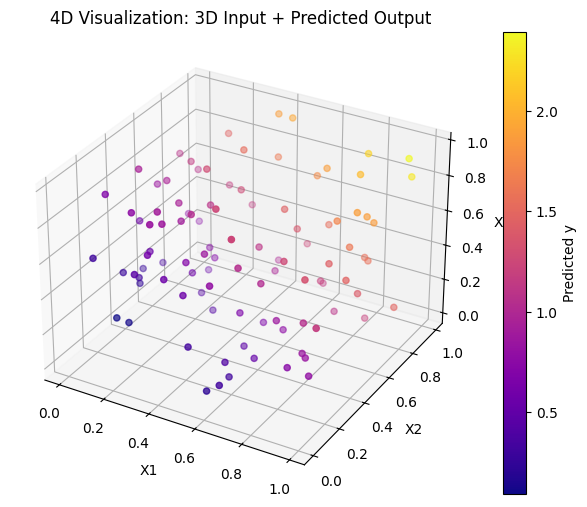

In [10]:
# 4D plot: X1, X2, X3 as position, y_pred as color
from mpl_toolkits.mplot3d import Axes3D

# Get predictions
y_pred = model(X_train).detach().numpy()

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_pred[:, 0], cmap='plasma')
plt.colorbar(sc, ax=ax, label='Predicted y')
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.set_title('4D Visualization: 3D Input + Predicted Output')
plt.show()
